# Efficient Frontier


## Install packages

In [2]:
! pip install numpy matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 39.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 51.5 MB/s  0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 41.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [matplotlib]8 [matplotlib]


## Efficient frontier plot and the optimal portfolio weights

- Randomly generates a large number of investment portfolios, calculates each portfolio's return, risk, and Sharpe ratio.
- Plots the efficient frontier with point colors representing Sharpe ratios.
- Red asterisk marks the optimal Sharpe ratio portfolio, blue X marks the minimum risk portfolio.
- Prints the corresponding stock weights in the console for direct use.

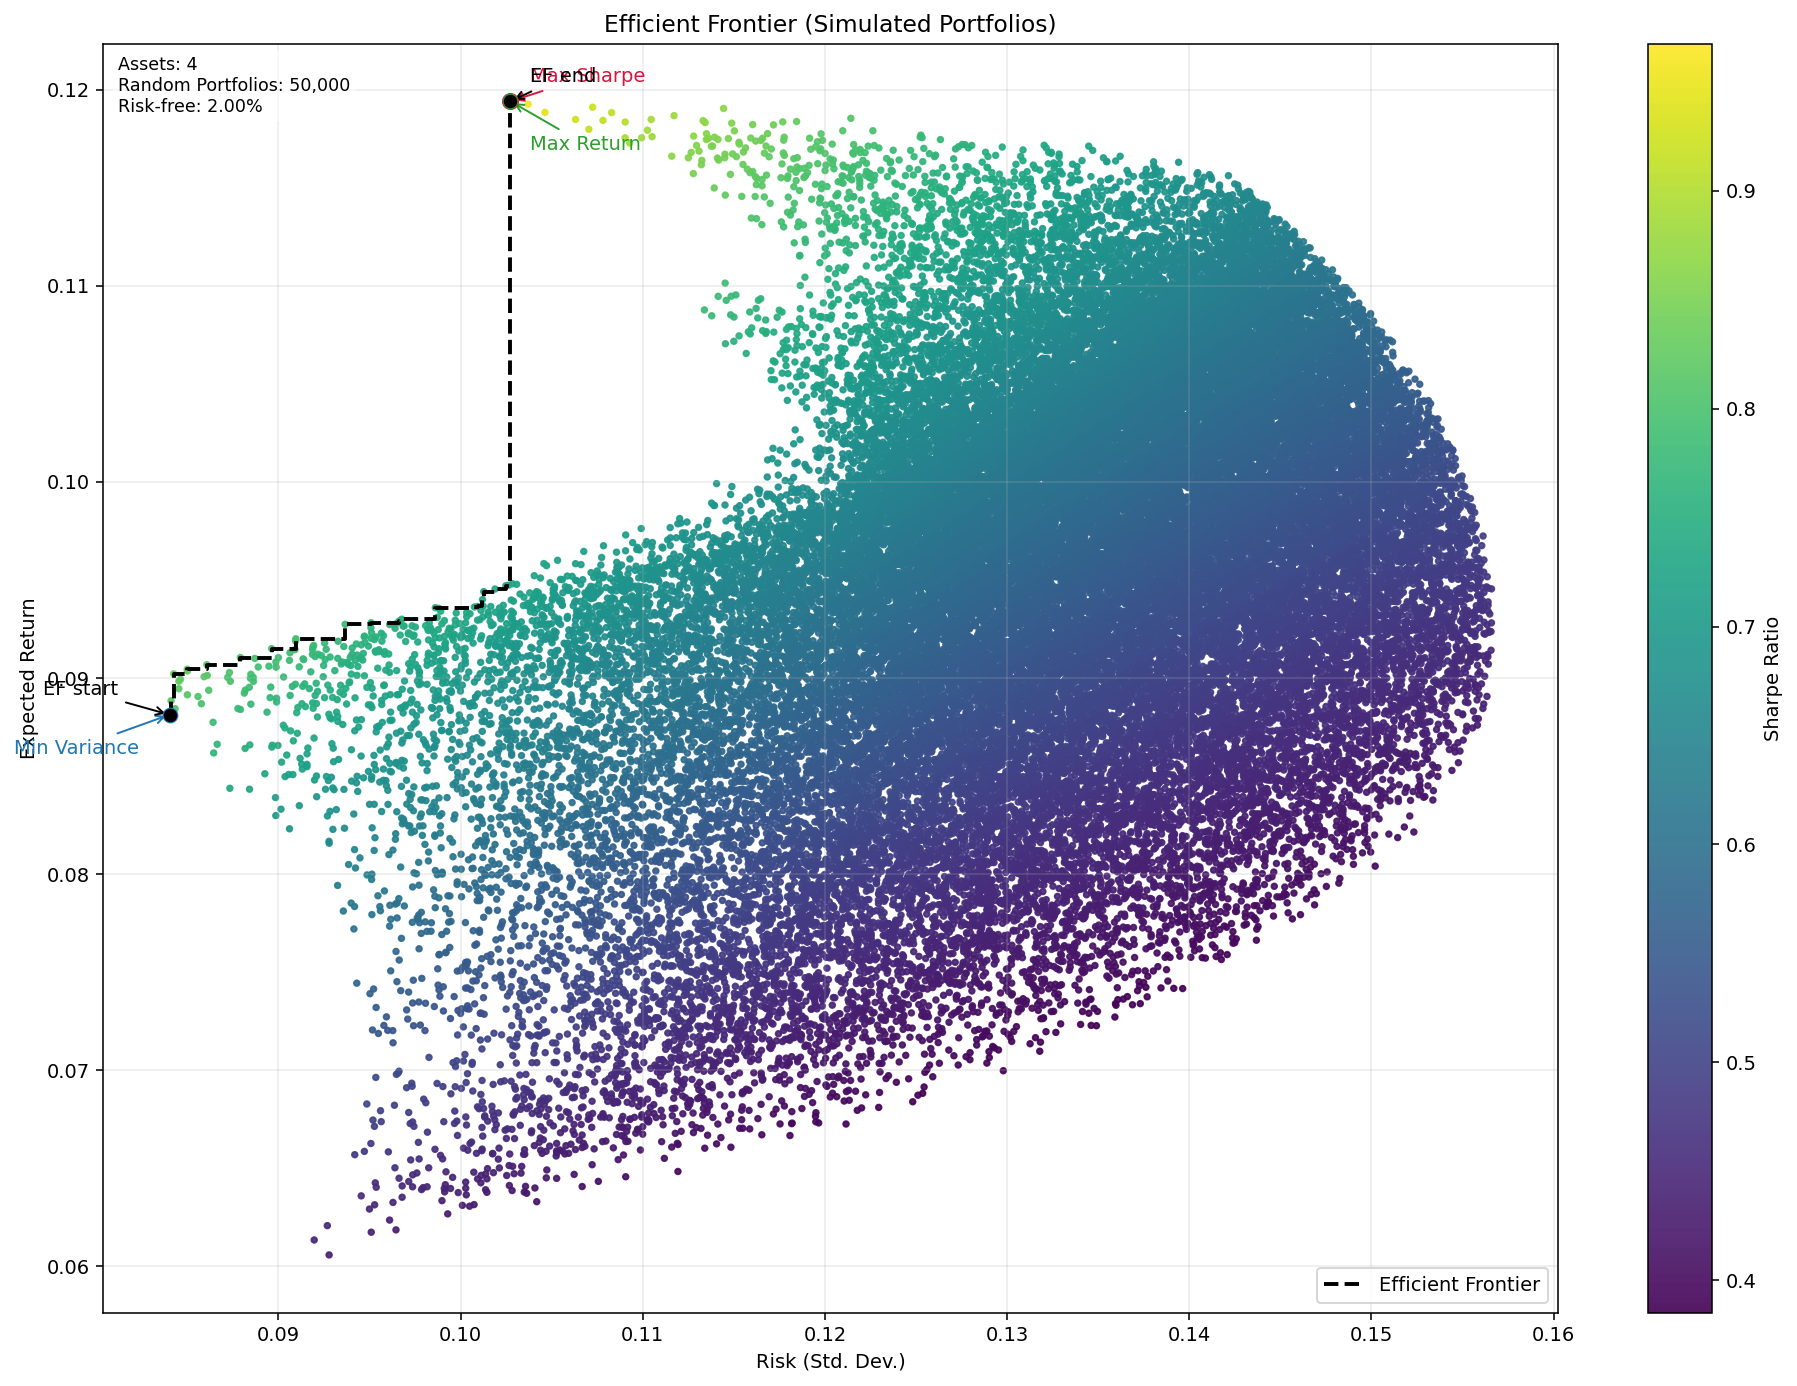

[Max Sharpe]
  Return: 0.1194  Risk: 0.1027  Sharpe: 0.9676
   - AAPL        : 98.677%
   - MSFT        :  0.535%
   - GOOGL       :  0.704%
   - AMZN        :  0.084%

[Min Variance]
  Return: 0.0881  Risk: 0.0840  Sharpe: 0.8108
   - AAPL        :  0.058%
   - MSFT        : 92.508%
   - GOOGL       :  6.748%
   - AMZN        :  0.686%

[Max Return]
  Return: 0.1194  Risk: 0.1027  Sharpe: 0.9676
   - AAPL        : 98.677%
   - MSFT        :  0.535%
   - GOOGL       :  0.704%
   - AMZN        :  0.084%



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def efficient_frontier_demo(
    mu=None, cov=None, rf=0.02, n_assets=10, n_port=50000, seed=7, asset_names=None
):
    """
    Efficient Frontier Simulation and Plotting  
    mu: Expected returns of assets (if None, random values will be generated)
    cov: Covariance matrix of asset returns (if None, random values will be generated)
    rf: Risk-free rate (default 2%)
    n_assets: Number of assets (default 10)
    n_port: Number of random portfolios to simulate (default 50,000)
    seed: Random seed for reproducibility (default 7)
    asset_names: List of asset names (if None, will generate default names)
    """
    rng = np.random.default_rng(seed)

    # ----- Asset Parameters -----
    if mu is None or cov is None:
        mu = rng.uniform(0.06, 0.18, n_assets)                 # Random expected returns
        A = rng.normal(size=(n_assets, n_assets))
        cov = A @ A.T
        cov = cov / np.max(np.diag(cov)) * 0.15                # Scale covariance matrix
    else:
        n_assets = len(mu)

    if asset_names is None:
        asset_names = [f"Asset_{i+1}" for i in range(n_assets)]

    # ----- Generate Random Portfolios (Long-only, Weights Sum to 1) -----
    W = rng.dirichlet(np.ones(n_assets), size=n_port)          # (n_port, n_assets)
    rets = W @ mu                                              # Portfolio returns
    vols = np.sqrt(np.einsum('ij,jk,ik->i', W, cov, W))        # Portfolio risk (std. dev.)
    sharpe = (rets - rf) / (vols + 1e-12)

    # ----- Efficient Frontier: Sort by Risk -> Cumulative Max Return -> Step Line -----
    order = np.argsort(vols)
    x, y = vols[order], rets[order]
    y_best = np.maximum.accumulate(y)
    keep = np.r_[True, y_best[1:] > y_best[:-1]]
    ef_x = x[keep]
    ef_y = y_best[keep]

    # ----- Key Portfolios -----
    i_ms = np.argmax(sharpe)               # Max Sharpe
    i_minv = np.argmin(vols)               # Min variance
    i_maxr = np.argmax(rets)               # Max return
    idx_ef_start = 0                       # EF start (min risk point)
    idx_ef_end = -1                        # EF end (max return point)

    # ===== Plot =====
    fig, ax = plt.subplots(figsize=(14, 10), dpi=140)
    sc = ax.scatter(vols, rets, c=sharpe, s=8, cmap='viridis', alpha=0.9)
    cb = plt.colorbar(sc, ax=ax)
    cb.set_label('Sharpe Ratio', rotation=90)

    ax.step(ef_x, ef_y, where='post', linestyle='--', linewidth=2, color='k',
            label='Efficient Frontier')

    # —— Annotations for key points: Max Sharpe, Min Variance, Max Return, EF start/end ——
    ax.scatter(vols[i_ms], rets[i_ms], s=60, c='crimson', zorder=5)
    ax.annotate('Max Sharpe',
                xy=(vols[i_ms], rets[i_ms]), xytext=(10,10),
                textcoords='offset points', color='crimson',
                arrowprops=dict(arrowstyle='->', lw=1, color='crimson'))

    ax.scatter(vols[i_minv], rets[i_minv], s=50, c='tab:blue', zorder=5)
    ax.annotate('Min Variance',
                xy=(vols[i_minv], rets[i_minv]), xytext=(-80,-20),
                textcoords='offset points', color='tab:blue',
                arrowprops=dict(arrowstyle='->', lw=1, color='tab:blue'))

    ax.scatter(vols[i_maxr], rets[i_maxr], s=50, c='tab:green', zorder=5)
    ax.annotate('Max Return',
                xy=(vols[i_maxr], rets[i_maxr]), xytext=(10,-25),
                textcoords='offset points', color='tab:green',
                arrowprops=dict(arrowstyle='->', lw=1, color='tab:green'))

    ax.scatter(ef_x[idx_ef_start], ef_y[idx_ef_start], s=35, c='k', zorder=5)
    ax.annotate('EF start', xy=(ef_x[idx_ef_start], ef_y[idx_ef_start]),
                xytext=(-65,10), textcoords='offset points', color='k',
                arrowprops=dict(arrowstyle='->', lw=1, color='k'))

    ax.scatter(ef_x[idx_ef_end], ef_y[idx_ef_end], s=35, c='k', zorder=5)
    ax.annotate('EF end', xy=(ef_x[idx_ef_end], ef_y[idx_ef_end]),
                xytext=(10,10), textcoords='offset points', color='k',
                arrowprops=dict(arrowstyle='->', lw=1, color='k'))

    ax.set_title('Efficient Frontier (Simulated Portfolios)')
    ax.set_xlabel('Risk (Std. Dev.)')
    ax.set_ylabel('Expected Return')
    ax.grid(True, alpha=0.25)
    ax.legend(loc='lower right')

    # Corner info box (small text explanation in the upper left corner)
    ax.text(0.01, 0.99,
            f'Assets: {n_assets}\nRandom Portfolios: {n_port:,}\nRisk-free: {rf:.2%}',
            va='top', ha='left', transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.6, lw=0))

    plt.tight_layout()
    plt.savefig('efficient_frontier.png', dpi=300)
    plt.show()

    # ===== Print Results =====
    def _print_portfolio(tag, idx):
        print(f'[{tag}]')
        print(f'  Return: {rets[idx]:.4f}  Risk: {vols[idx]:.4f}  Sharpe: {sharpe[idx]:.4f}')
        for name, w in zip(asset_names, W[idx]):
            print(f'   - {name:<12}: {w:>7.3%}')
        print()

    _print_portfolio('Max Sharpe', i_ms)
    _print_portfolio('Min Variance', i_minv)
    _print_portfolio('Max Return', i_maxr)

    # Return results as a dictionary
    results = {
        'mu': mu, 'cov': cov, 'rf': rf,
        'weights': W,
        'returns': rets, 'risks': vols, 'sharpe': sharpe,
        'ef_x': ef_x, 'ef_y': ef_y,
        'idx_max_sharpe': i_ms,
        'idx_min_var': i_minv,
        'idx_max_return': i_maxr
    }
    return results


# ================== 运行示例 ==================
if __name__ == "__main__":
    # Input your own data here
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']
    mean_returns = np.array([0.12, 0.09, 0.06, 0.11])  # mean returns of the assets
    cov_matrix = np.array([
    [0.10**2, 0.02, 0.04, 0.03],
    [0.02, 0.08**2, 0.01, 0.02],
    [0.04, 0.01, 0.09**2, 0.02],
    [0.03, 0.02, 0.02, 0.11**2]
    ])  # covariance matrix of asset returns
    results = efficient_frontier_demo(mu=mean_returns, cov=cov_matrix, rf=0.02, asset_names=tickers)
